In [1]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

from seaborn import despine
import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

from IPython.display import Image

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Example 3: Classifying images

In this notebook, we will be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

This dataset contains 28 x 28 pixel grey-scale images of clothing pieces.

Overall, the dataset contains 10 different categories of clothing.

We can load the dataset with the `fashion_mnist.load_data()` function from `tensorflow.keras.datasets`.

(More details on [Tensorflow](https://www.tensorflow.org) and [Keras](https://keras.io) will follow later).

In [2]:
from tensorflow.keras import datasets

In [3]:
# load Fashion MNIST data
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data() #datasets.cifar10.load_data()

# the class names
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

This dataset is already divided into a training and test dataset, each containing 60000 and 10000 distinct grey scale images:

In [4]:
train_images.shape, test_images.shape

((60000, 28, 28), (10000, 28, 28))

To make these images easily digestable for a neural network, we will normalize the range of the pixel values to a range between 0 and 1:

In [5]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = np.expand_dims(train_images / 255.0, -1), np.expand_dims(test_images / 255.0, -1)

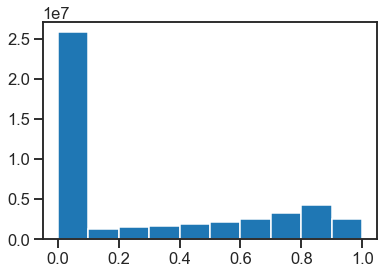

In [6]:
_ = plt.hist(train_images.ravel())

Ok, the normalization worked; The high frequency of 0 values is based on the consistent black background of each image

Let's take a look at a few of the training examples:

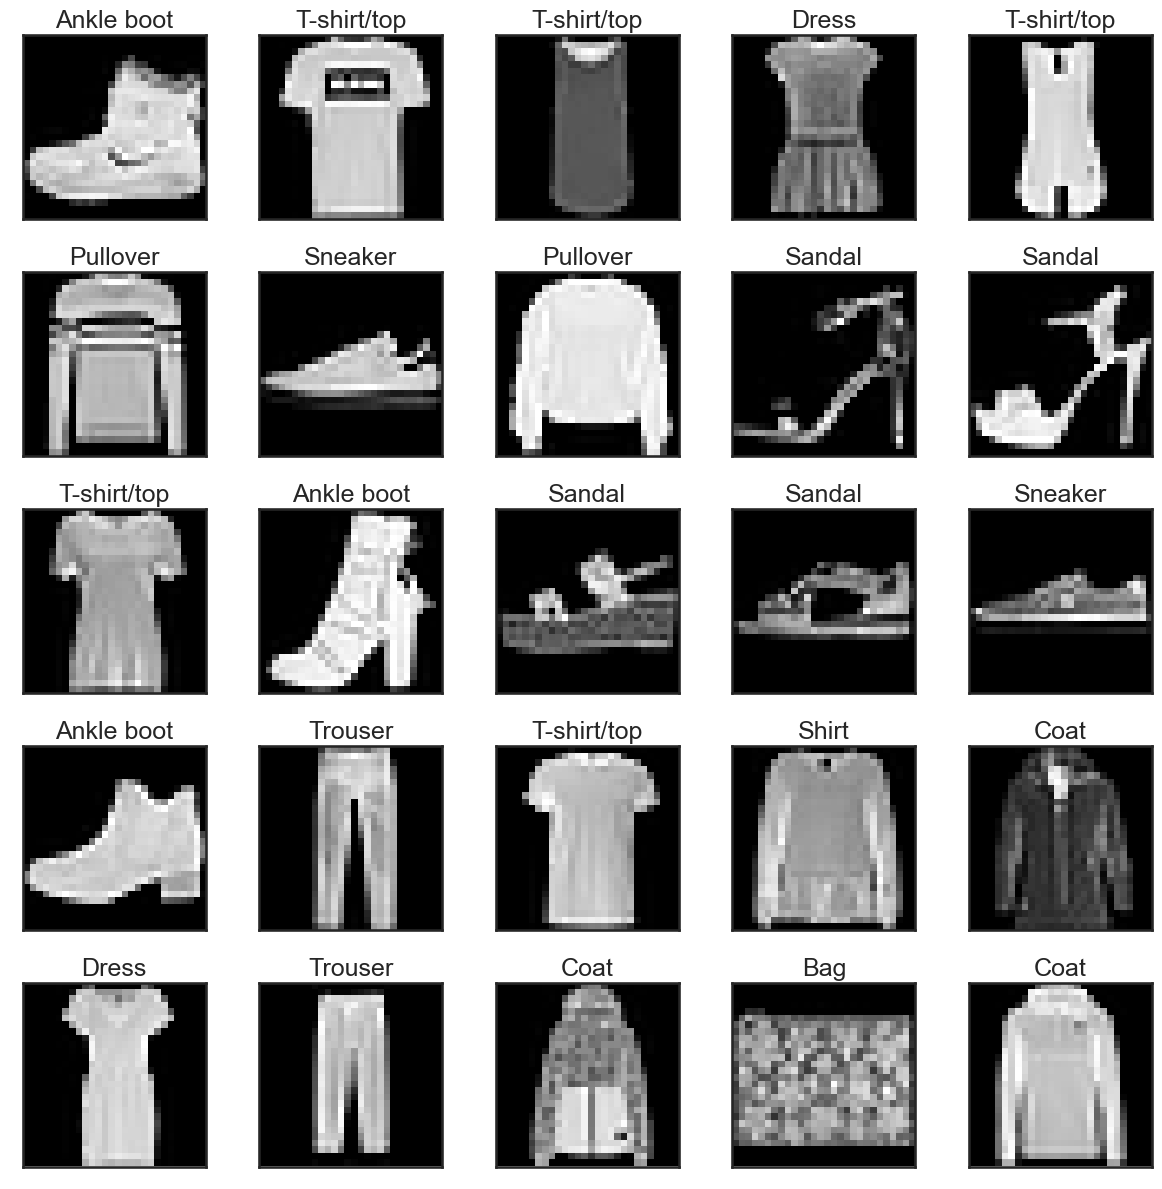

In [7]:
fig, axs = plt.subplots(5,5,figsize=(12,12), dpi=100)
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.imshow(train_images[i,...,0], cmap='gray')
    ax.set_title(class_names[train_labels[i]])
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.savefig('figures/Figure-2-0_Fashion-MNIST.png', dpi=600)

# 2. Convolutional Neural Networks

## 2.1 Biological inspiration

One way of classifying this dataset would be to flatten each sample to a vector of 784 values (28 x 28) and to feed it to a fully-connected artificial neural network (as we did with the hand-written digit data in the previous notebook (1-Neural-Networks-Backpropagation.ipynb)).

However, there is another common type of artificial neural networks that was specifically designed for computer vision problems. 

These networks are called *convolutional neural networks* and are (very) loosely inspired by our knowledge of the the neurobiological processes of human vision.

On a superficial level, the human brain processes visual information in the following steps (see also Figure below):

First, a projection of the image is registered on the retina. The retina is composed of various types of neurons, which are each sensitive to specific characteristics of the perceived image (each neuron has a receptive field, describing an area in the image for which it is sensitive).

These neurons are connected to the optical nerve and send their signals along the visual system of the brain.

The visual system itself is composed of multiple brain reqions (encompassing the [visual cortex](https://en.wikipedia.org/wiki/Visual_cortex#Primary_visual_cortex_(V1)), which seem to respond to different characteristics of the perceived image.

Importantly, the complexity of these characteristics increases as you travel along the visual system, such that lower level regions are more sensitive to basic propoerties of the perceived image (such as orientatoin and contrast), while higher level regions respond to more complex stimuli (famous examples are the [fusiform face area](https://en.wikipedia.org/wiki/Fusiform_face_area) and [parahippocampal place area](https://en.wikipedia.org/wiki/Parahippocampal_gyrus) which specifically respond to faces and scenes).

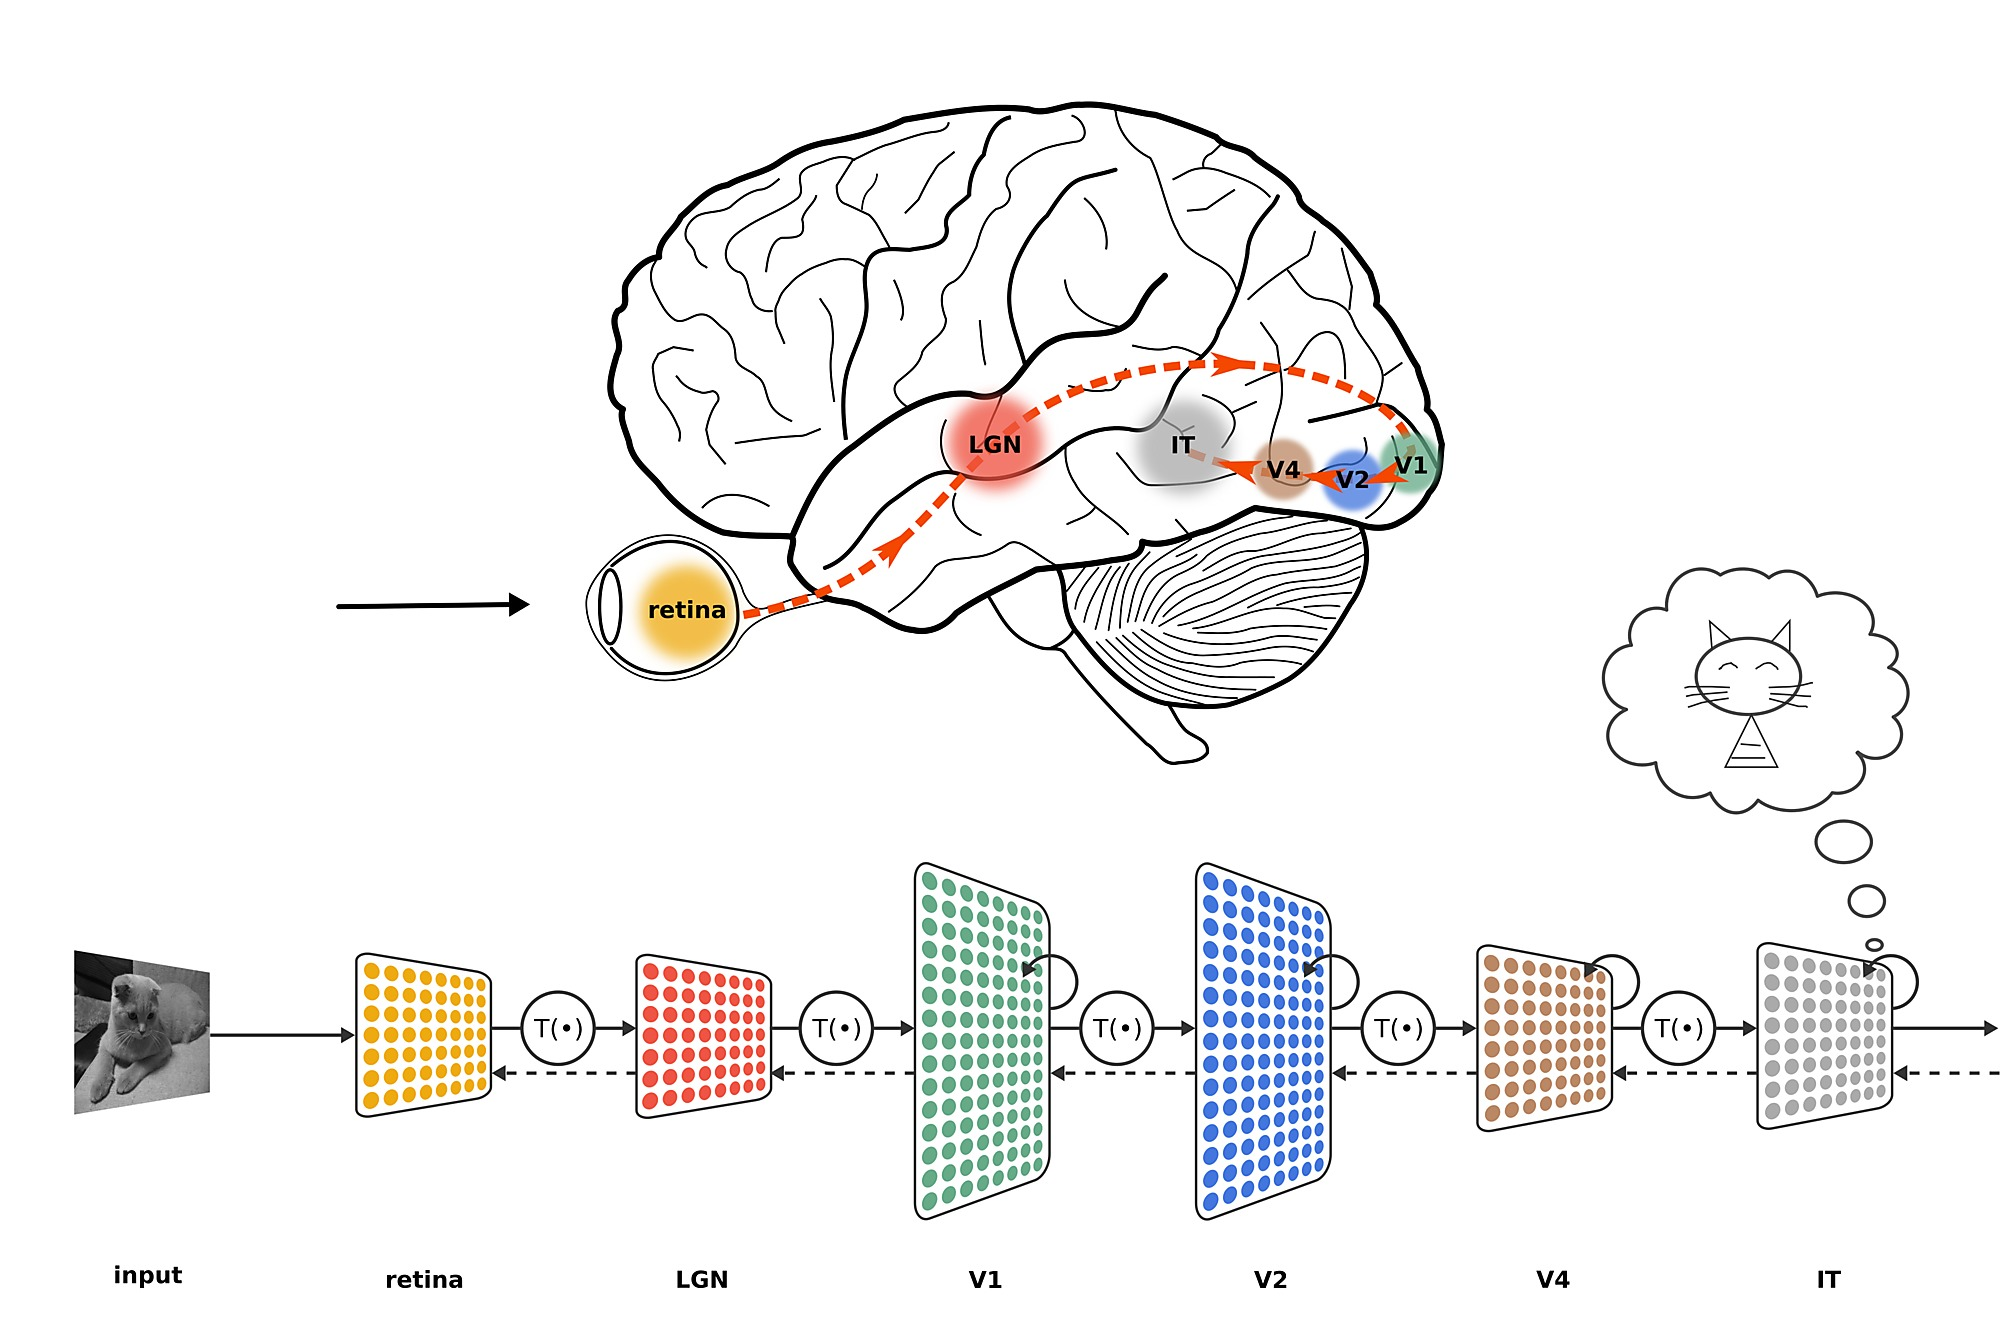

In [8]:
Image(filename='materials/images/free-use/Human-Vision.jpg')

*Adapted from:* Kubilius, Jonas (2017): Ventral visual stream. figshare. Figure. https://doi.org/10.6084/m9.figshare.106794.v3 

## 2.2. Convolution Kernels (or filters)

This idea of neurons that respond to specific elements of a visual input has been transferred to computer vision, by the use of convolution kernels (or filters).

Each kernel conceptually represents a neuron and is composed of a small square matrix (typically with a size 3x3 or 5x5 values).

To create an activation map with a kernel (indicating for each location of the image whether the element is present for which the kernel is sensitive), we perform a [convolution](https://en.wikipedia.org/wiki/Kernel_(image_processing)) between the kernel and image.

Computationally, this means nothing else than moving the kernel over the image. At each location, the values of the kernel are multiplied with the values of the image at this location and summed. Similarly to a perceptron, a bias term is added to the resulting weighted sum and it is scaled through a non-linear activation function ($\phi$). Typically, convolution kernels are activated through the rectified linear unit function ([ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))). Overall, this process results in one value for each location of the activation map that the kernel is applied to:

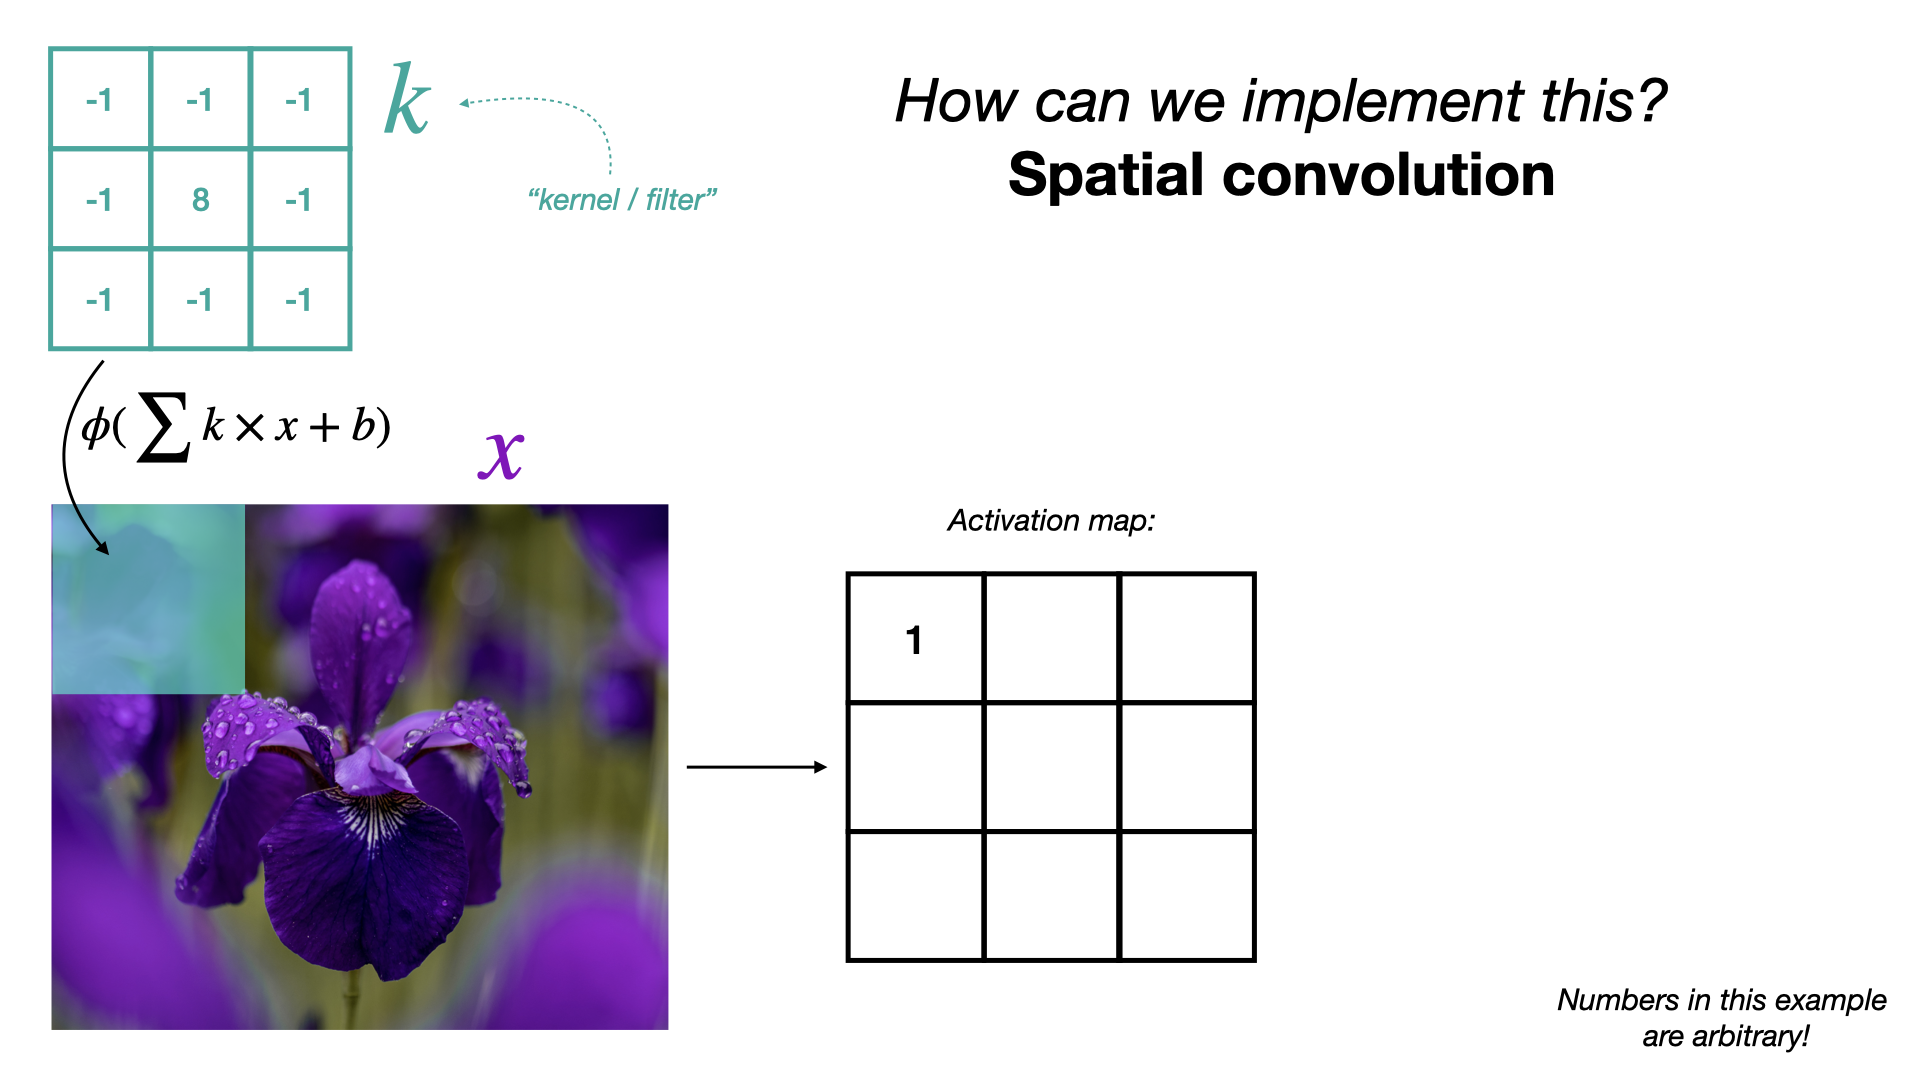

In [9]:
Image(filename='materials/images/free-use/Spatial-Convolution.png')

Importantly, the distance between the application of the kernel to the input image is called the *stride*. A stride of 1 pixel generally creates an activation map of the same size as the input image, while larger strides reduce the size of the activation map:

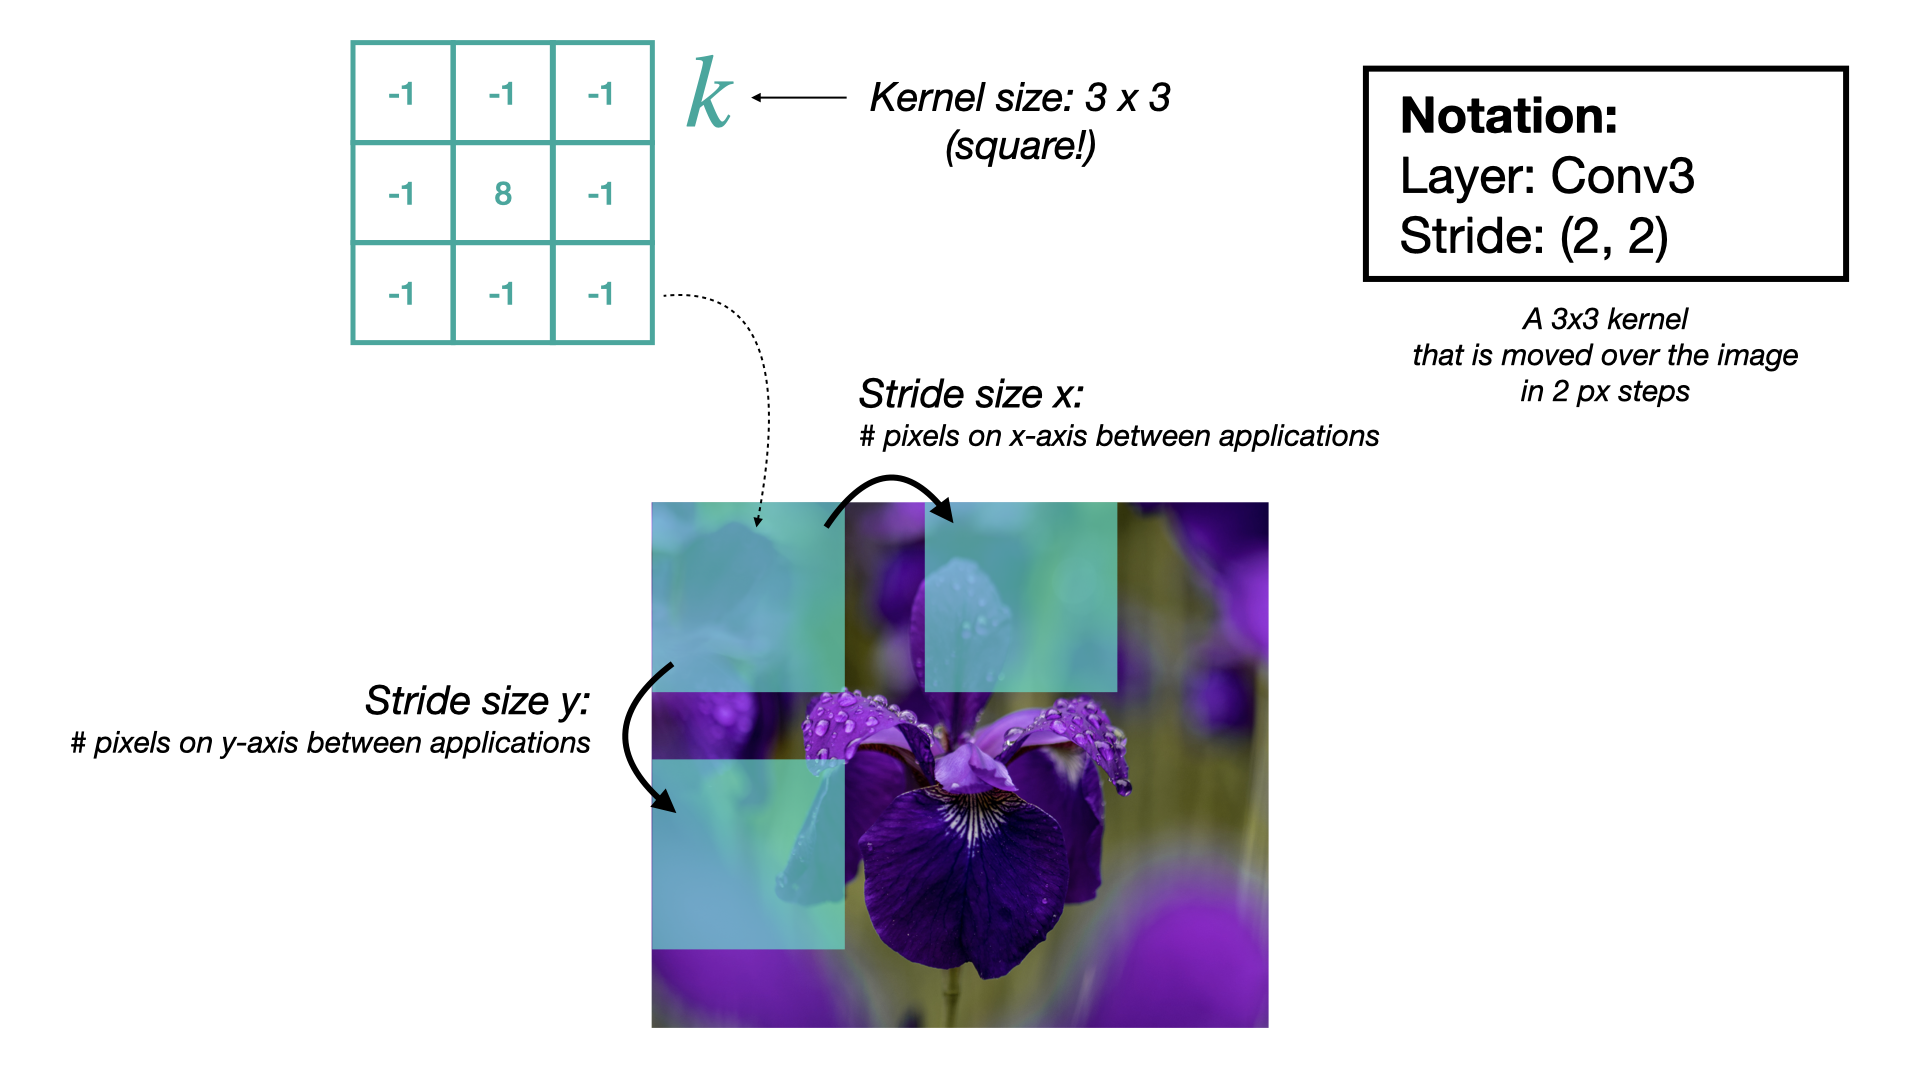

In [10]:
Image(filename='materials/images/free-use/Stride.png')

Let's try this ourselves with some data:

In [11]:
def spatial_convolution_2D(image, kernel, bias=0):
    """spatial 2D convolution between an image and 
    a kernel with stride size 1
    """
    m, n = kernel.shape[:2]
    if (m == n):
        yin, xin = image.shape[:2]
        yout = yin - m + 1
        xout = xin - m + 1
        convolved_image = np.zeros((yout,xout))
        for i in range(yout):
            for j in range(xout):
                convolved_image[i,j] = np.sum(image[i:i+m, j:j+m]*kernel) + bias
    return convolved_image

Here, we will be using a few exemplary edge detection kernels (based on the [Sobel Operator](https://en.wikipedia.org/wiki/Sobel_operator)):

In [12]:
# a kernel that is sensitive to vertical edges:

vertical_edge_kernel = np.zeros((3,3))
vertical_edge_kernel[:,0] = 1
vertical_edge_kernel[:,2] = -1
vertical_edge_kernel[1,0] = 2
vertical_edge_kernel[1,2] = -2
vertical_edge_kernel

array([[ 1.,  0., -1.],
       [ 2.,  0., -2.],
       [ 1.,  0., -1.]])

In [13]:
# a kernel that is sensitive to horizontal edges:

horizontal_edge_kernel = np.zeros((3,3))
horizontal_edge_kernel[0] = 1
horizontal_edge_kernel[2] = -1
horizontal_edge_kernel[0,1] = 2
horizontal_edge_kernel[2,1] = -2
horizontal_edge_kernel

array([[ 1.,  2.,  1.],
       [ 0.,  0.,  0.],
       [-1., -2., -1.]])

In [14]:
# a kernel that is sensitive to all edges:

edge_detection_kernel = -1.0 * np.ones((3,3))
edge_detection_kernel[1,1] = 8
edge_detection_kernel

array([[-1., -1., -1.],
       [-1.,  8., -1.],
       [-1., -1., -1.]])

So what kind of activation maps do we get when we convolve these three kernels with a few examples of our dataset?

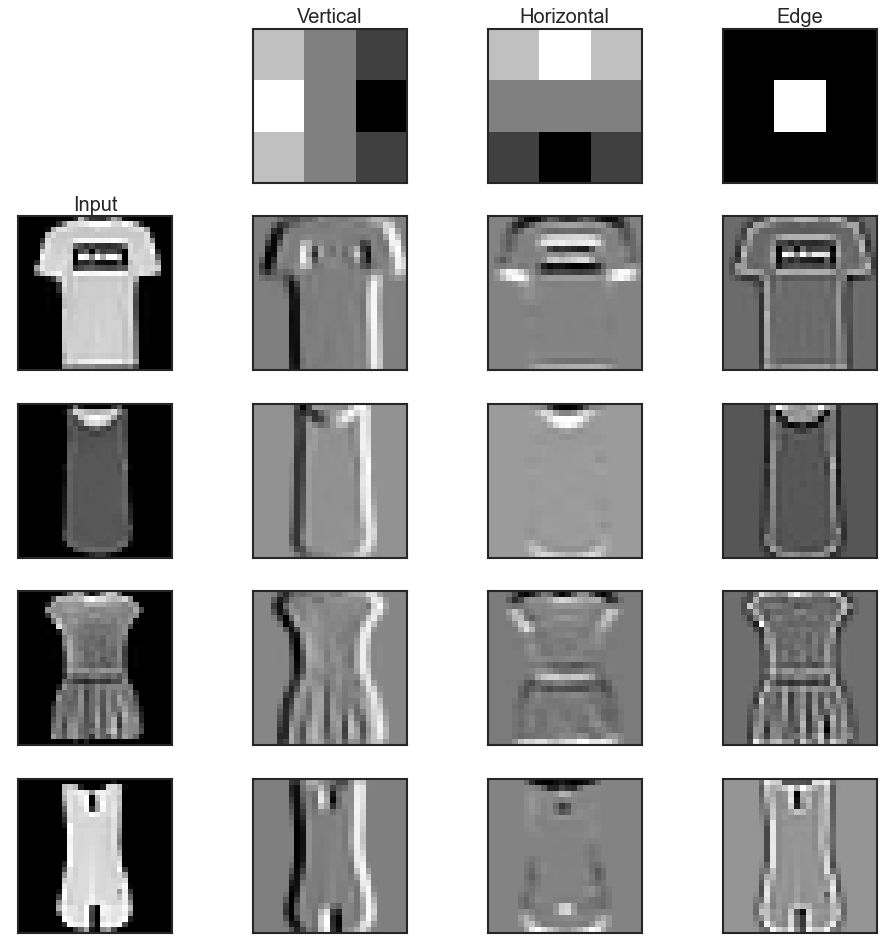

In [15]:
fig, axs = plt.subplots(5,4,figsize=(12,12), dpi=80)
axs[0,0].remove()

# plot kernels
axs[0,1].imshow(vertical_edge_kernel, cmap='gray')
axs[0,2].imshow(horizontal_edge_kernel, cmap='gray')
axs[0,3].imshow(edge_detection_kernel, cmap='gray') 

# plot activation maps
for i in range(1,5):
    
    # input image
    axs[i,0].imshow(train_images[i,...,0], cmap='gray')

    # vertical
    convolved_img = spatial_convolution_2D(train_images[i,...,0], vertical_edge_kernel)
    axs[i,1].imshow(convolved_img, cmap='gray')
    
    # horizontal
    convolved_img = spatial_convolution_2D(train_images[i,...,0], horizontal_edge_kernel)
    axs[i,2].imshow(convolved_img, cmap='gray')
    
    # edge
    convolved_img = spatial_convolution_2D(train_images[i,...,0], edge_detection_kernel)
    axs[i,3].imshow(convolved_img, cmap='gray')

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

# label axes
axs[1,0].set_title('Input')
axs[0,1].set_title('Vertical')
axs[0,2].set_title('Horizontal')
axs[0,3].set_title('Edge')

# save
fig.tight_layout()
fig.savefig('figures/Figure-2-1_Edge-Detection-Kernels.png', dpi=600)

As expected, the activation maps resulting from the spatial convolution highlight the characteristics of the image that each kernel is sensitive to: vertical edges, horizontal edges, all edges!

## 2.3 Stacking many kernels to a convolutional neural network



A convolutional neural network is nothing more than a sequence of convolution layers, which are each composed of a stack of convolution kernels!

Importantly, the kernels of each layer are applied to the activation maps resulting from the previous layer. This trick allows higher-level convolution kernels (which are deeper into the network) to learn very abstracted features, based on the activation maps of the lower-level convolution kernels (for more details on this, see this amazing paper: https://distill.pub/2018/building-blocks/).

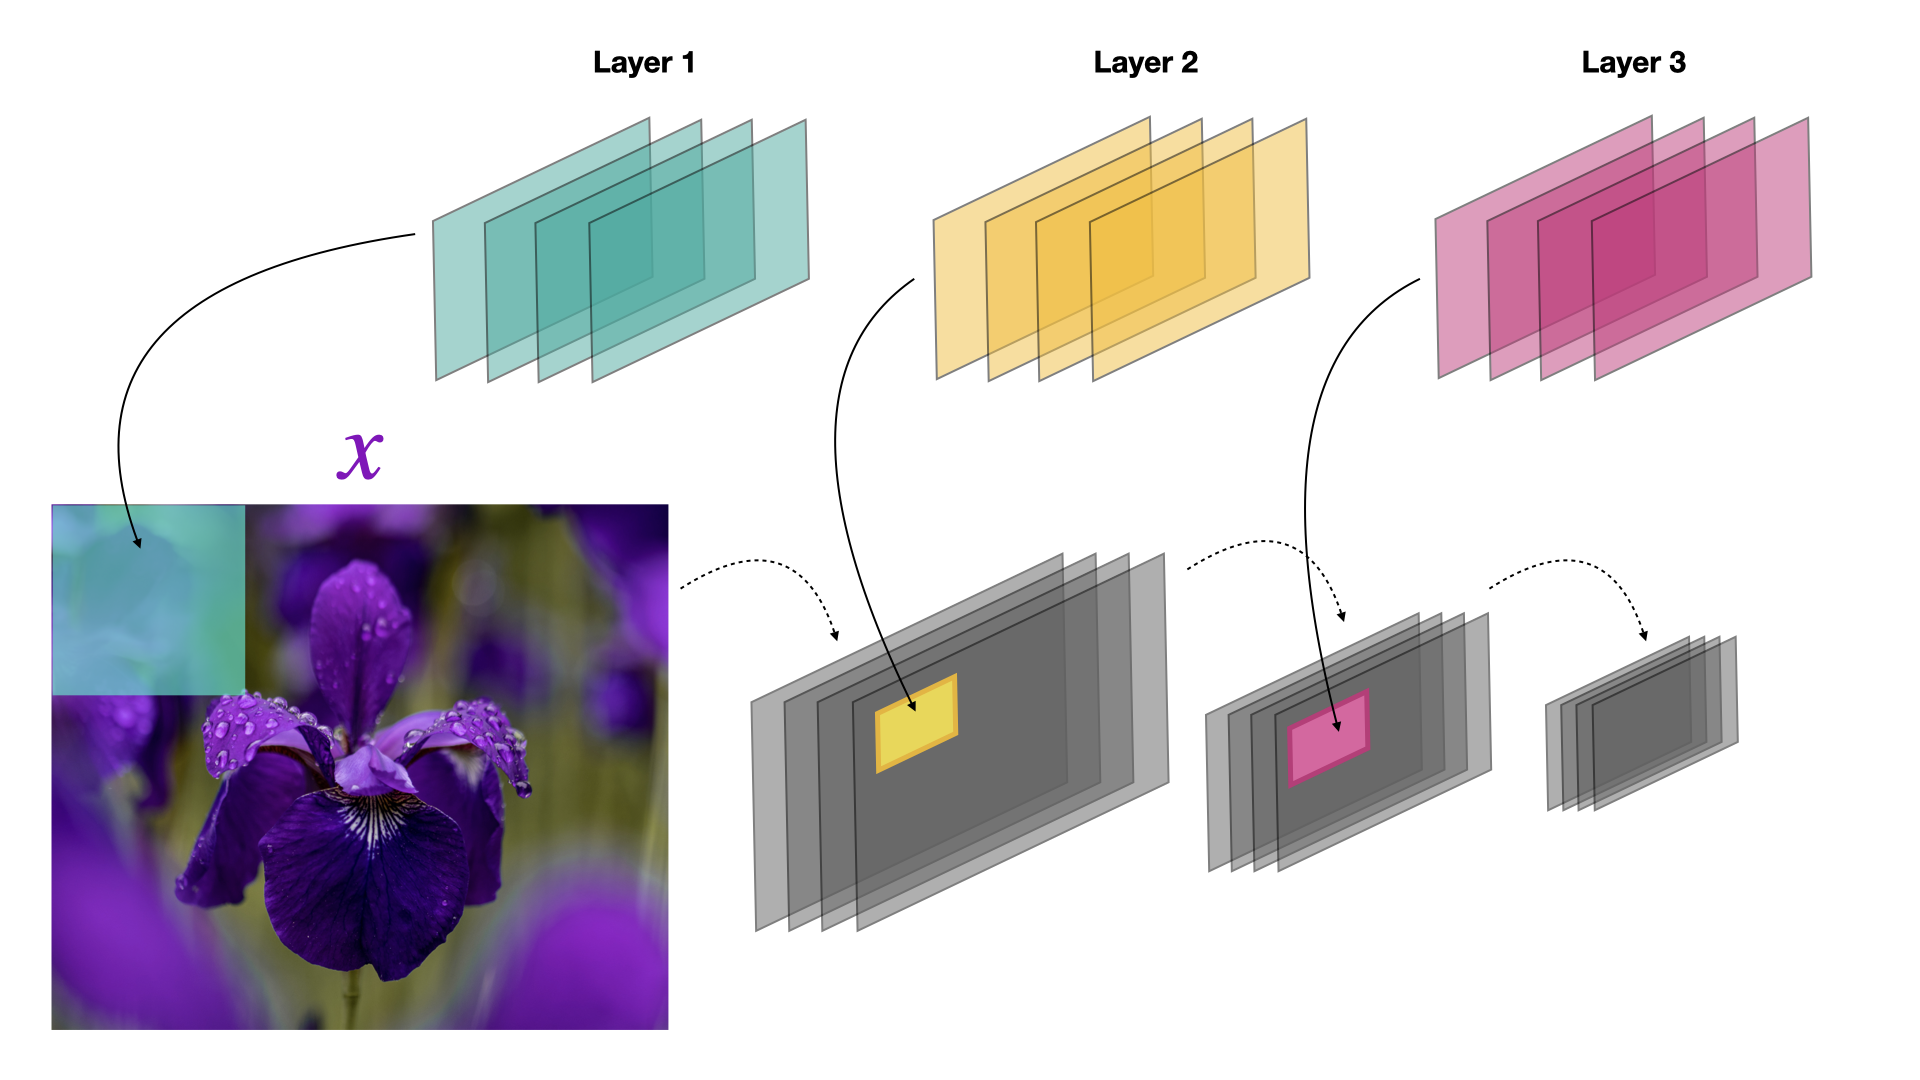

In [16]:
Image(filename='materials/images/free-use/Convolutional-Neural-Network.png')

## 2.4 Pooling kernels

Classical CNN architectures contain one more type of kernel, which is used to decrease the size of the activation maps (ie., to down-sample the image).

These kernels are called *pooling kernels*.

Two classical pooling kernels are *average* and *max* pooling.

These do nothing else then return the average or max value over their receptive field.

Importantly, they are moved over the image in non-overlapping steps: A pooling kernel of size 2x2 would therefor be moved over the image in 2 pixel steps, thereby down-sampling its input by a factor of 2:

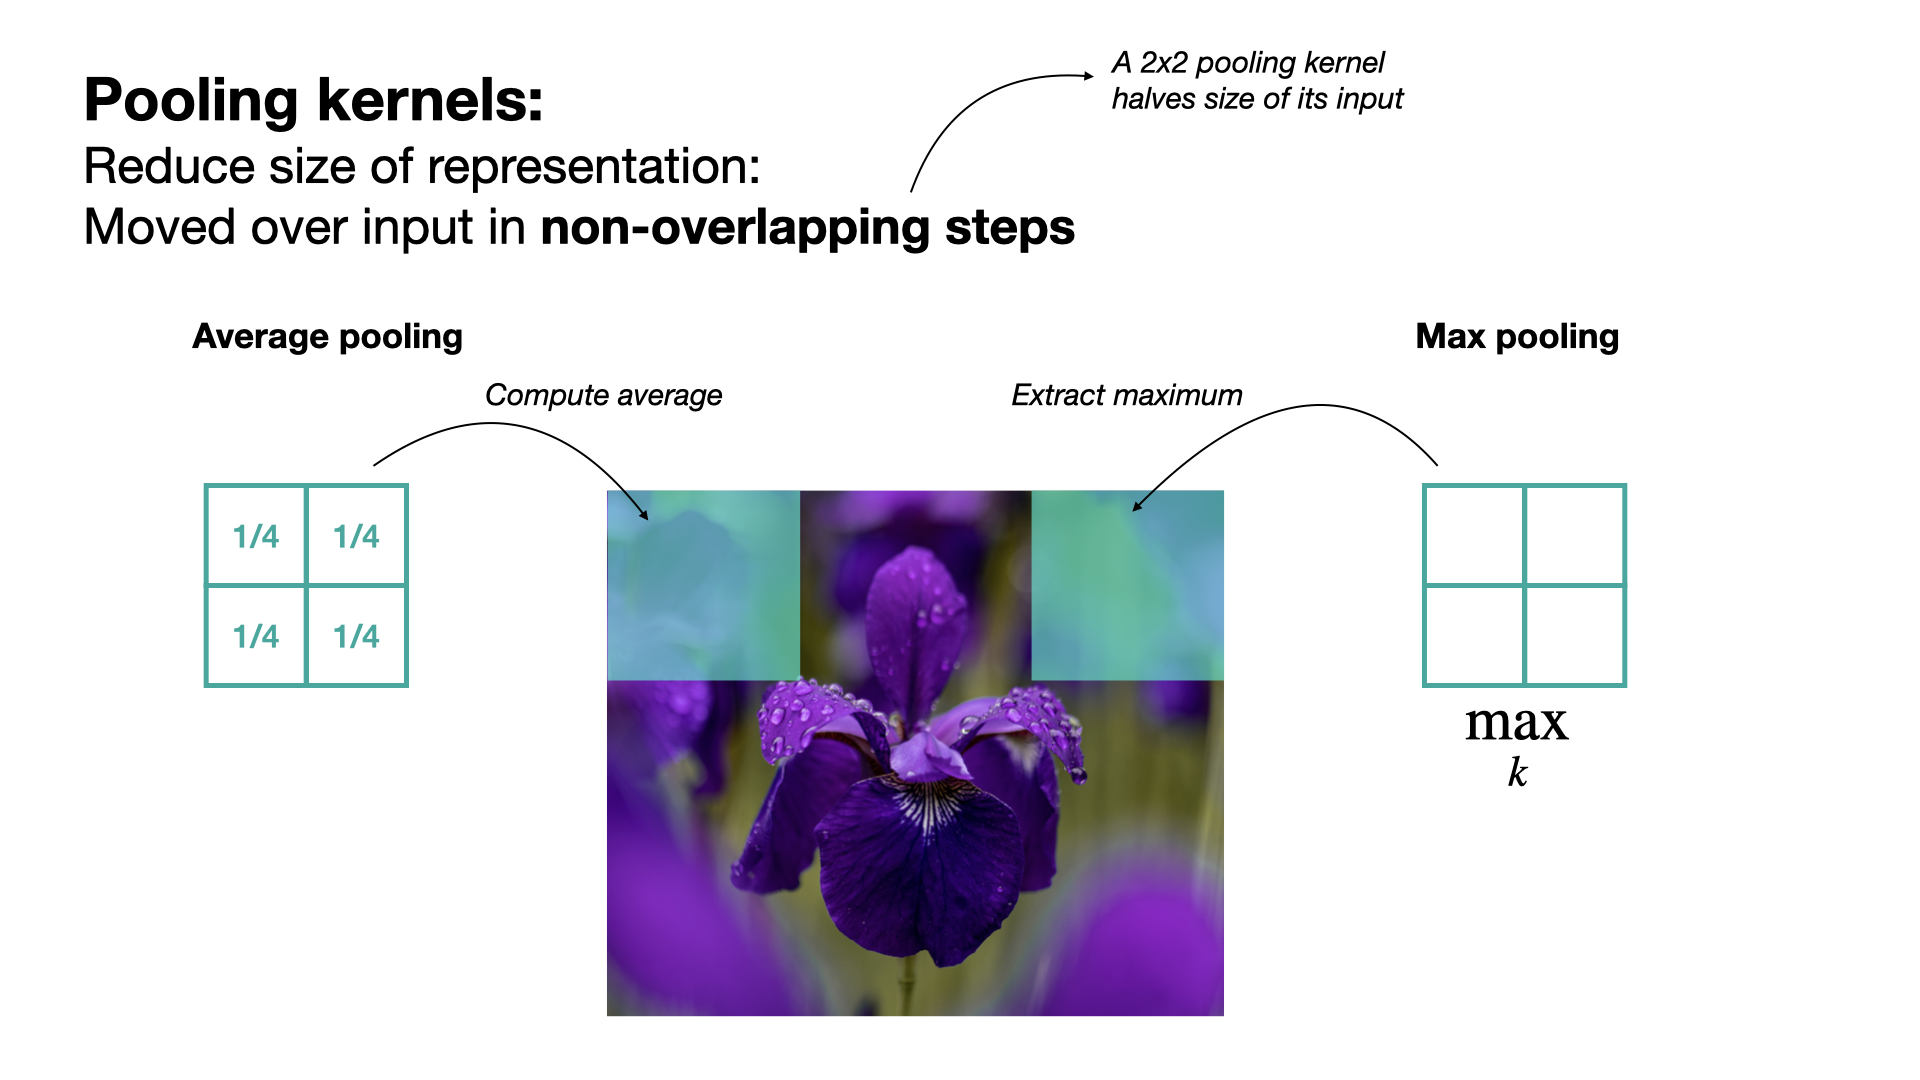

In [17]:
Image(filename='materials/images/free-use/Pooling-Kernels.png')

## 2.5 Building a convolutional neural network in Tensorflow

Enough with the theory, let's build our first CNN!

For this we will be using the most commonly used deep learning library [Tensorflow](https://www.tensorflow.org).

Tensorflow is a high-level Python library that makes it extremely easy to build and train complicated, state-of-the-art, articical neural netwok architectures.

Specifically, we will be using the [Keras](https://www.tensorflow.org/guide/keras/sequential_model) library that is part of Tensorflow.

In Keras, a model can be specified by the use of the `Sequential` model class.

Calling `models.Sequential` initiates an empty model.

We can then sequentially add layers to this model from the `layers` module of keras. Here, we will be focusing on the `Conv2D`layer type (representing a 2D-convolution layer) as well as the `AveragePooling2D`and `Dense` layer types. Dense layers represented fully connected artifical neural network layers, such as those that we built in our previous notebook (1-Neural-Networks-Backpropagation.ipynb).

To allow for classification, we two dense layers to the end of our network, with 32 and 10 neurons each.

To this end, we first flatten the activation maps resulting from the last convoltionl layer, such that they are each represented as a single row vector:

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, Model

In [19]:
# initialize a sequential model
model = models.Sequential()

# add our first convolution layer
model.add(layers.Conv2D(filters=4, # this layer contains 4 kernels
                        kernel_size=(3, 3), # each being 3 x 3 values large
                        activation='relu', # and activated through a ReLu activation function
                        input_shape=(28, 28, 1))) # this is the shape of the input

# now lets add a 2x2 average pooling layer:
model.add(layers.AveragePooling2D(pool_size=(2,2)))   

# and then another convolution layer:
model.add(layers.Conv2D(filters=16, # this time containing 16 kernels
                        kernel_size=(3, 3), # each again with a size of 3x3 values
                        activation='relu'))

# another 2x2 average pooling layer:
model.add(layers.AveragePooling2D(pool_size=(2,2))) 

# and our last convolution layer
model.add(layers.Conv2D(filters=32, # with 32 kernels
                        kernel_size=(3, 3),
                        activation='relu'))

# add dense output layers
model.add(layers.Flatten()) # flatten the activation maps of the last convolution layer
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) # one neuron for each of the 10 classes in our dataset

Ok, lets take a look at our full model:

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
average_pooling2d (AveragePo (None, 13, 13, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 16)        592       
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 288)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                9

This is looking good.

We can see that the size of the activation maps is decreasing as the data is passed through the network.

We can further see that the activation maps of each convolution layer are stacked along the last dimension (look at the Output Shape column).

The flat activation maps resulting from our last convolution kernel have a size of 288 values and the output layer contains 10 neurons (one for each class).

Overall this model has almost 15,000 trainable parameters - mostly resulting from the first dense layer (this underlines why down-sampling the data is important)!

## 2.6 Training the model

Now that we have build our model, let's train it:

In Keras, this is requires two steps: 

First, we compile the model, by calling `model.compile`. Here, Keras builds a computational graph for the model in the background, automatically specifying all gradient computations (which we previously needed to specify by hand). In this step, we also specify the loss function that we want to optimize for during training. Similar to our previous examples, we are using a sparse version of the [cross entropy loss for multiple classes](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html). 

In this steps, we also define an optimizer: In our previous examples, we used a vanilla version of stochastic gradient descent. There exist, however, more sophisticated optimizers that extend the idea of stochastic gradient descent (for an overview, see [here](https://keras.io/api/optimizers/) and [here](https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/)). Here, we are using rmsprop (the default in keras).

Lastly, we specify another metric (in addition to the loss) which we want keras to track during training. Here, we are telling keras to track the predictive accuracy during training:

In [21]:
model.compile(optimizer='rmsprop',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 

In the second step, we only specify the training and validation data for the training, as well as the batch size and number of training epochs that we want to run. 

An epoch is defined as an entire iteration over the training dataset (10 training epochs with our dataset will therefore result in 10 * N(training samples) / batch_size training steps):

In [ ]:
np.random.seed(1421)
tf.random.set_seed(1421)
history = model.fit(x=train_images,
                    y=train_labels,
                    epochs=10, 
                    batch_size=32,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 8s 5ms/step - loss: 1.8188 - accuracy: 0.6462 - val_loss: 1.7864 - val_accuracy: 0.6748
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.7624 - accuracy: 0.6989 - val_loss: 1.7653 - val_accuracy: 0.6957
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.7519 - accuracy: 0.7085 - val_loss: 1.7494 - val_accuracy: 0.7105
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.7444 - accuracy: 0.7158 - val_loss: 1.7433 - val_accuracy: 0.7163
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 1.7379 - accuracy: 0.7220 - val_loss: 1.7451 - val_accuracy: 0.7137
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 1.7319 - accuracy: 0.7279 - val_loss: 1.7377 - val_accuracy: 0.7224
Epoch 7/10
 162/1875 [=>............................] - ETA: 8s - loss: 1.7277 - accuracy: 0.7305

Let's take a look at the training statistics:

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,6))

# plot training loss
axs[0].plot(history.history['accuracy'], label='Training data')
axs[0].plot(history.history['val_accuracy'], label = 'Test data')
axs[0].set_xlabel('Training epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0, 1])
axs[0].legend(loc='lower right')
despine(ax=axs[0])

# plot confusion matrix for training and test datasets
for i, (label, X, y) in enumerate(zip(['Training', 'Test'],
                                      [train_images, test_images],
                                      [train_labels, test_labels])):
    y_pred = model.predict(X).argmax(axis=1)
    acc = np.mean(y_pred == y)
    axs[1+i].set_title('{} data\nMean Acc.: {}%'.format(label, np.round(acc*100, 2)))
    conf_mat = confusion_matrix(y, y_pred, normalize='true')
    sns.heatmap(np.round(conf_mat, 2), annot=True,
                ax=axs[1+i], vmin=0, vmax=1,
                annot_kws={'fontsize': 14})
    if i == 0:
        axs[1+i].set_ylabel('True label')
    axs[1+i].set_xlabel('Predicted label')

# save figure
fig.tight_layout()
fig.savefig('figrues/Figure-2-2_Training-Stats.png', dpi=600)

Great! Our model is able to classify almost $90$% of the images in the test dataset correctly.

However, it is also slightly overfitting the training dataset (as indicated by the higher predictive accuracy in the training data).

# 3. Exersice:

Below you will find a copy of the code that we just ran to build and train our CNN.

- Try adapting the specifications of the individual layers (e.g., reduce / increase the number of kernels or change the size of the kernels (e.g., to 5x5)) and see how it changes the performance of the model.


- You can also try out different optimizers (e.g., 'adam' or 'SGD'), batch sizes, and number of training epochs.


- Lastly, you can also try to remove the pooling layers from the model and replace it with an increasing stride size of the convolution layer that is subsequent to them. An increase in stride size should have a similar down-sampling effect as a pooling layer!


**Try to not be too extreme** (e.g., by having more than 200 kernels per layer, more than 10 layers, or a very large batch size); This might otherwise crash the notebook that you are currently running; Remember we are running this with very limited resources on the Jupyter Binder Servers.

In [ ]:


# 1. Model Specification:
# ----------------
# initialize a sequential model
model = models.Sequential()

# add our first convolution layer
model.add(layers.Conv2D(filters=4, # this layer contains 4 kernels
                        kernel_size=(3, 3), # each being 3 x 3 values large
                        activation='relu', # and activated through a ReLu activation function
                        input_shape=(28, 28, 1))) # this is the shape of the input

# now lets add a 2x2 average pooling layer:
model.add(layers.AveragePooling2D(pool_size=(2,2)))   

# and then another convolution layer:
model.add(layers.Conv2D(filters=16, # this time containing 16 kernels
                        kernel_size=(3, 3), # each again with a size of 3x3 values
                        activation='relu'))

# another 2x2 average pooling layer:
model.add(layers.AveragePooling2D(pool_size=(2,2))) 

# and our last convolution layer
model.add(layers.Conv2D(filters=32, # with 32 kernels
                        kernel_size=(3, 3),
                        activation='relu'))

# dense output layers
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax')) # one neuron for each of the 10 classes in our dataset
# ----------------





# 2. Compiling the model:
# ----------------
model.compile(optimizer='rmsprop',
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) 
# ----------------

In [ ]:
np.random.seed(1421)
tf.random.set_seed(1421)
history = model.fit(x=train_images,
                    y=train_labels,
                    epochs=10, 
                    batch_size=32,
                    validation_data=(test_images, test_labels))

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(20,6))

# plot training loss
axs[0].plot(history.history['accuracy'], label='Training data')
axs[0].plot(history.history['val_accuracy'], label = 'Test data')
axs[0].set_xlabel('Training epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([0, 1])
axs[0].legend(loc='lower right')
despine(ax=axs[0])

# plot confusion matrix for training and test datasets
for i, (label, X, y) in enumerate(zip(['Training', 'Test'],
                                      [train_images, test_images],
                                      [train_labels, test_labels])):
    y_pred = model.predict(X).argmax(axis=1)
    acc = np.mean(y_pred == y)
    axs[1+i].set_title('{} data\nMean Acc.: {}%'.format(label, np.round(acc*100, 2)))
    conf_mat = confusion_matrix(y, y_pred, normalize='true')
    sns.heatmap(np.round(conf_mat, 2), annot=True,
                ax=axs[1+i], vmin=0, vmax=1,
                annot_kws={'fontsize': 14})
    if i == 0:
        axs[1+i].set_ylabel('True label')
    axs[1+i].set_xlabel('Predicted label')

# save figure
fig.tight_layout()
fig.savefig('figrues/Figure-2-2_Training-Stats.png', dpi=600)

# 4. One last bonus: Activation Maximization

For this analysis, we use the [VGG16](https://arxiv.org/abs/1409.1556) architecture, which was pre-trained in on the [ImageNet](http://www.image-net.org) dataset. 

In [ ]:
vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
vgg16.summary()

In [ ]:
from deep_dream import run_deep_dream

In [ ]:
np.random.seed(2135)
tf.random.set_seed(2135)

fig, axs = plt.subplots(3,4,figsize=(20,15), dpi=200)

# define random input image
random_input = np.random.uniform(0,255,(200,200,3)).astype(np.int)

# iterate three layers from VGG16
for i, layer_name in enumerate(['block1_conv1', 'block2_conv2', 'block3_conv3', 'block4_conv3']):
    
    # Create the feature extraction model
    layer_output = vgg16.get_layer(layer_name).output
    for j, k in enumerate([0,10,35]):
        print('Processing layer: {}, kernel: {}'.format(layer_name, k))
        dream_model = tf.keras.Model(inputs=vgg16.input,
                                     outputs=layer_output[...,k])

        # run deep dream
        img = run_deep_dream(dream_model, random_input,
                             show_progress=False)

        # plot
        axs[j,i].imshow(img.numpy())
        axs[j,i].set_title('Layer: {} (Kernel: {})'.format(layer_name, k))
        axs[j,i].set_xticks([])
        axs[j,i].set_yticks([])
        despine(ax=axs[j,i])
    
fig.tight_layout()
fig.savefig('figures/Figure-2-4_VGG16-Deep-Dream.png', dpi=600)